In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve,plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score,balanced_accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

###  <font color='navy'>Data Exploration </font>

In [2]:
# read imdb movie review sentiment file into pandas
rt_reviews = pd.read_csv('rottenReview_backup_xl.csv')
rt_reviews.head(2)

,Reviews,StarRating
0,Narrated the whole time...really weird and not...,STAR_0_5
1,"Decent watch, could watch again, but hard to r...",STAR_3


In [3]:
# rename columns to review and StarRating
rt_reviews.columns = ['review', 'StarRating']

In [4]:
#Dimensions of the dataset
rt_reviews.shape

(169669, 2)

In [5]:
# examine the dataframe, no missing data
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169669 entries, 0 to 169668
Data columns (total 2 columns):
review        169669 non-null object
StarRating    169669 non-null object
dtypes: object(2)
memory usage: 2.6+ MB


In [6]:
# the reviews have html tags. double quotations, brackets, hyphen and emojis that should be removed in preprocessing.
rt_reviews.iloc[74, 0]

'This is a very stupid movie it is a waste pf money and talent, Anne sorry but in this movie she is very bad, and rebel , well, os rebel most of her movies are very bad this is not the exception this movie nobody will remember it , thanks god 😒'

In [7]:
# How many categories of star rating
rt_reviews.StarRating.unique()
# Ranges from 0.5 star to 5 stars (10 levels)

array(['STAR_0_5', 'STAR_3', 'STAR_2', 'STAR_1', 'STAR_3_5', 'STAR_5',
       'STAR_2_5', 'STAR_4', 'STAR_1_5', 'STAR_4_5'], dtype=object)

In [8]:
# Examie the distribution of ratings
rt_reviews.StarRating.value_counts().sort_index()

STAR_0_5    12371
STAR_1       8751
STAR_1_5     4550
STAR_2       9119
STAR_2_5     7347
STAR_3      14293
STAR_3_5    14454
STAR_4      26209
STAR_4_5    13274
STAR_5      59301
Name: StarRating, dtype: int64

In [9]:
# Examie the distribution of ratings as percentage
rt_reviews.StarRating.value_counts(normalize=True).sort_index()
# roughly 25% are below 3 star , imbalanced dataset

STAR_0_5    0.072913
STAR_1      0.051577
STAR_1_5    0.026817
STAR_2      0.053746
STAR_2_5    0.043302
STAR_3      0.084240
STAR_3_5    0.085189
STAR_4      0.154471
STAR_4_5    0.078235
STAR_5      0.349510
Name: StarRating, dtype: float64

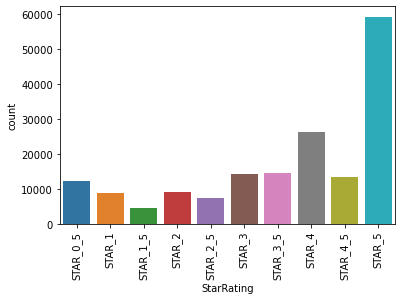

In [10]:
# plot the positive / negative classes as frequencies
s = sns.countplot(x='StarRating', data=rt_reviews, order=rt_reviews.StarRating.value_counts().index.sort_values())
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [11]:
# longest, shortest and avg review lengths
review_length = rt_reviews.review.str.len()
print('longest review is', review_length.max(), 'chracters long')
print('shortest review is',review_length.min(), 'chracters long')
print('average review is ',int(review_length.mean()), 'chracters long')

longest review is 55269 chracters long
shortest review is 10 chracters long
average review is  218 chracters long


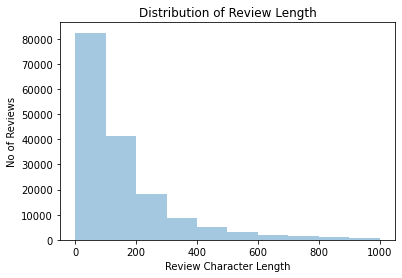

In [12]:
s = sns.distplot(review_length, bins=[0,100,200,300,400,500,600,700,800,900,1000], kde=False)
s.set_xlabel('Review Character Length')
s.set_ylabel('No of Reviews')
s.set_title('Distribution of Review Length')
plt.show()

###  <font color='navy'>Pre-processing </font>

In [13]:
# convert StarRating into numerical as sklearn expects target variable to be numeric
# 0.5 t0 2.5 => negative sentiment and 3-5 stars = positive sentiment (5 levels in each)
mapping = {'STAR_0_5': 0, 'STAR_1':0, 'STAR_1_5':0, 'STAR_2':0, 'STAR_2_5':0, 
          'STAR_3':1, 'STAR_3_5':1, 'STAR_4':1, 'STAR_4_5':1, 'STAR_5': 1}

# create a new column sentiment
rt_reviews['sentiment'] = rt_reviews.StarRating.map(mapping)

In [14]:
# 75% positive and 25% negative sentiment, slighty imbalaced dataset
rt_reviews.sentiment.value_counts(normalize=True)

1    0.751646
0    0.248354
Name: sentiment, dtype: float64

In [15]:
# check the target column is mapped correctly
rt_reviews.head()

,review,StarRating,sentiment
0,Narrated the whole time...really weird and not...,STAR_0_5,0
1,"Decent watch, could watch again, but hard to r...",STAR_3,1
2,It wasn't as bad as the critics said it was. A...,STAR_3,1
3,I actually thought this was funny. The ending ...,STAR_3,1
4,"I liked this better the first time I saw it, w...",STAR_3,1


In [16]:
# Text processing steps

#convert everything to lower case
rt_reviews['review_clean'] = rt_reviews.review.str.lower()

# remove numbers 
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace('[0-9]+', '') # match one or more digits

# remove html tags
regex_html = r'<\s*[^>]*>|<\s*/\s*>' #this regular exression will match all html tags
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace(regex_html, '')

# remove Punctuations
regex_punctuations = r'[^\w\s]' #match anything not a digit/letter/underscore or space
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace(regex_punctuations, ' ')
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace('_', '')  # remove underscore too

In [17]:
rt_reviews['review_clean'].head()

0    narrated the whole time   really weird and not...
1    decent watch  could watch again  but hard to r...
2    it wasn t as bad as the critics said it was  a...
3    i actually thought this was funny  the ending ...
4    i liked this better the first time i saw it  w...
Name: review_clean, dtype: object

In [18]:
# Instantiate the CountVectorizer
countvec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
bag = countvec.fit_transform(rt_reviews.review_clean)

In [19]:
# look at the dimensions of the sparse matrix
bag.shape
# vocabulary of 69.5K words , lets try to reduce this

(169669, 69563)

##### <b>*Stemming* </b>

Stemming helps to discover the root forms of the words 
    watch, watching, watched => watch (root form)
    do, did, does, done => do (root form)

Stemming transforms words to their root forms. However the stem may not be not a valid word in the language (eg: movie => movi)

The function getRootWord takes in a paragrpah and turns the words in the paragraph to their root form

In [20]:
# stemmer will only work on tokenized words not sentences. We will define a function to do this. 
def getRootWords(sentence) :
    #instantiate stemmer 
    stemmer=SnowballStemmer("english") # the english stemmer is an improvement on the original porter stemmer
    
    #tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # stem the tokens
    root_tokens= [stemmer.stem(word) for word in tokens]
    
    # join words together to form sentence again 
    root_sentence = ' '.join(root_tokens)
    
    return root_sentence

In [21]:
#  Stemming Example: watching, watch, watched =>'watch' and movie, movies +> movi
sentence = '''I love watching movies. I have watched over 50 movies since the lockdown began. In fact I will watch one movie tonight'''
getRootWords(sentence)

'i love watch movi . i have watch over 50 movi sinc the lockdown began . in fact i will watch one movi tonight'

In [22]:
# stem each review to reduce the vocabulary 
rt_reviews['review_stemmed'] = rt_reviews.review_clean.apply(getRootWords)

In [23]:
# if we stem text then we must stem stopwords too
stemmer=SnowballStemmer("english")
stop_words_stemmed = [stemmer.stem(word) for word in ENGLISH_STOP_WORDS]

In [24]:
# see how many words changed from iriginal stop words
print(set(stop_words_stemmed).difference(ENGLISH_STOP_WORDS))

{'describ', 'everywher', 'befor', 'everyth', 'someth', 'alreadi', 'noth', 'sever', 'wherea', 'ani', 'thenc', 'otherwis', 'everi', 'hereaft', 'els', 'whereaft', 'togeth', 'somewher', 'everyon', 'anywher', 'onc', 'sixti', 'whatev', 'whi', 'inde', 'sincer', 'thereaft', 'wherebi', 'becam', 'veri', 'anyth', 'fifti', 'alon', 'becaus', 'twenti', 'moreov', 'mani', 'sometim', 'forti', 'empti', 'alway', 'someon', 'meanwhil', 'wherev', 'themselv', 'onli', 'nowher', 'nobodi', 'besid', 'noon', 'whenc', 'therebi', 'yourselv', 'therefor', 'henc', 'dure', 'abov', 'whenev', 'afterward', 'howev', 'anyon', 'ourselv', 'elsewher', 'hundr', 'perhap', 'cri', 'herebi', 'anoth', 'sinc', 'pleas', 'becom', 'twelv'}


In [25]:
# stemmed bag of words
countvec_stem= CountVectorizer(stop_words=stop_words_stemmed)
bag_stem = countvec_stem.fit_transform(rt_reviews.review_stemmed)
bag_stem.shape

(169669, 48678)

*Stemming has reduced no of features from 69563 to 48678K, so a significant reduction*

In [26]:
# create a word cloud
corpus = rt_reviews.review_stemmed.str.cat(sep=' ') #concat all reviews into one big string
word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(corpus)

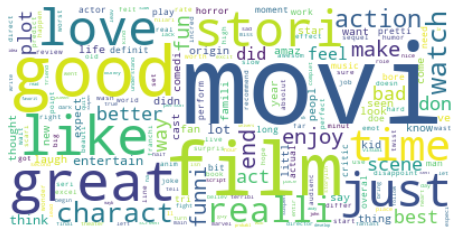

In [27]:
# Display the generated wordcloud image (both postive and negative)
plt.figure(figsize=(8,5)) 
plt.imshow(word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [28]:
# split the dataframe into positive and negative reviews
positive_reviews = rt_reviews[rt_reviews.sentiment == 1] # positive sentiment
negative_reviews = rt_reviews[rt_reviews.sentiment == 0] # negative sentiment

In [29]:
#generate positive and negative word clouds
positive_corpus = positive_reviews.review_stemmed.str.cat(sep=' ')
positive_word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(positive_corpus)

negative_corpus = negative_reviews.review_stemmed.str.cat(sep=' ')
negative_word_cloud= WordCloud(background_color='white',stopwords=stop_words_stemmed, collocations=False).generate(negative_corpus)

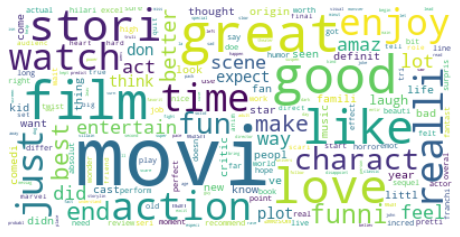

In [30]:
# show the positive wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(positive_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

The word cloud of positive reviews have words such as great, good, best, fun, entertain etc. This is what one would have expected to see from postive review corpus

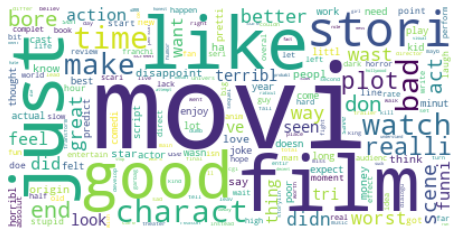

In [31]:
# show the negative wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(negative_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

At first it is puzzling that word cloud of negative rviews features words such as good, funny etc. One possibility is actual revies had phrases such 'not good', 'not funny' often and a single bag of words has taken these words out of context.

##### <b>*Context & ngrams* </b>

BOW shortcomings- Context is lost:
    review 1 -  This movie is dull, not good
    review 2 -  This movie is good, not dull.
a simple of bag of words approach will not be able to distinguish between the two, even though the meanings are inverted.

n_grams:
CountVectorizer allows a way to consider group of 2 (bigram)  words to together. (not bad, not happy). In general n_grams will group n words together. n_gram is essence a way to capture more context. 

Here we consider unigrams(each word) and bigrams (2 words together). 
Taking bigrams into account will exponentially increase the features but we will use max_features parameter to limit the features.

In [32]:
print(len(stop_words_stemmed))

# update the stop_words to include a few words that may make the context clearer (eg: not not good, not bad etc)
mylist = ['not', 'never', 'alway', 'interest']
for word in mylist : 
    stop_words_stemmed.remove(word)

#remove a few movie related stopwords showed in the word clouds
movie_related_stopwords = ['movi', 'film', 'act', 'watch', 'scene']
stop_words_stemmed = stop_words_stemmed + movie_related_stopwords
# print the no of updated stopwords
print(len(stop_words_stemmed))

318
319


##### <b>*Random undersampling to create a balanced dataset* </b>

In [33]:
# size of total negative reviews
total_neg_reviews = negative_reviews.shape[0]
total_neg_reviews

42138

In [34]:
# size of positive reviews
positive_reviews.shape[0]

127531

*I use the same seed value of 1411 in all my code when reproducibility is required. it is random and not chosen to get optimal reslts. It has meaning for me because 14th of November is my daughter's birthday*

In [35]:
#set seed
SEED = 1411 # for reproducibility

In [36]:
#we will build a random sample positive review that is the same size as negative views
np.random.seed(SEED)
mask = np.random.choice(positive_reviews.index.values, total_neg_reviews, replace=False)
positive_reviews_sampled = positive_reviews.loc[mask]

In [37]:
#dataframe consisting of postive reviews not sampled
mask_excluded = set(positive_reviews.index).difference(set(mask))
print(len(mask_excluded))
positive_reviews_not_sampled = positive_reviews.loc[mask_excluded]

85393


In [38]:
#sampled positive dataframe has the same no of reviews as negative
positive_reviews_sampled.shape[0]

42138

In [39]:
#create a balanced dataset by concatenating positive and negative dataframes
rt_reviews_balanced = pd.concat([negative_reviews,positive_reviews_sampled], axis=0)
rt_reviews_balanced.shape

(84276, 5)

In [40]:
# Define X and target 
X = rt_reviews_balanced.review_stemmed
y = rt_reviews_balanced.sentiment.values # as numpy array

In [41]:
# also create test sets for the postive reviews excluded (to check the classification accuracy later)
X_postive_data = positive_reviews_not_sampled.review_stemmed
y_positive = positive_reviews_not_sampled.sentiment.values

In [42]:
#split the data into training and test sets, note this step is done even before Vectorizing the reviews(text). 

# 80% training 20% test, dataset split in stratifed fashion (becuase positive and negative were joined)
X_data_train, X_data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

#### Bag-of-words Representation

Bag of words : tokenize the document then count up all the tokens. The idea is more frequent a word, more central or important it might be to the text.  

In [43]:
# max no of features (unigrams and bigrams)
MAX_FEATURES=1000 # roughly 2% of the total unigrams

#  build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
countvec = CountVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
bag = countvec.fit_transform(X_data_train) 

# Create X_train and X_test
X_train_bow= bag.toarray() # scikit learn cant work with sparse matrices, so convert bag of words to numpy array

# No refitting. Only transform using the CountVectorizer fitted on training data.  Absolutely no cheating !!
X_test_bow = countvec.transform(X_data_test).toarray()

#samples excluded
X_positive_bow = countvec.transform(X_postive_data)

In [44]:
# get a list features selected based on term frequency (5000 in total)
features = countvec.get_feature_names()

In [45]:
# find all bigrams amoung the selected features 
bigrams = [word for word in features if ' ' in word]
print(len(bigrams))
# of the 1000 features selected, roughly 10% are bigrams

94


In [46]:
# print some bigrams
print(bigrams [:5])

['action pack', 'action sequenc', 'ant man', 'bad guy', 'begin end']


In [47]:
# check if we are right to allow some stopwords
print([word for word in bigrams if word.startswith('not')])

['not bad', 'not best', 'not expect', 'not funni', 'not good', 'not great', 'not like', 'not realli', 'not recommend', 'not scari', 'not sure', 'not worth']


Intuitively it makes sense that bigrams may help determine sentiment. 

In [48]:
# find the top most frequent words
sum_words = bag.sum(axis=0)  # contains the sum of each word occurrence in all texts in the corpus
words_freq = {word :sum_words[0, idx] for word, idx in countvec.vocabulary_.items()}

#sort the dictionary by term frequency
words_freq = {word: freq for word, freq in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)} 

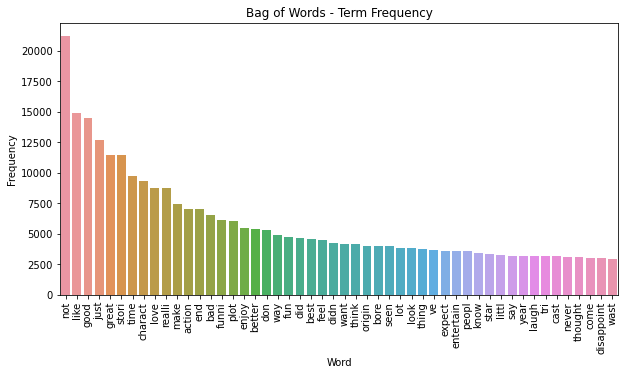

In [49]:
#plot the frequencies of the top 50 words.
vocabulary_sorted = list(words_freq.keys())
freq_sorted = list(words_freq.values())
plt.figure(figsize=(10,5))
s=sns.barplot(x=vocabulary_sorted[:50],y=freq_sorted[:50])
s.set_title('Bag of Words - Term Frequency')
s.set_xlabel('Word')
s.set_ylabel('Frequency')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

###  <font color='navy'>1.  Train and Compare ML Models using Bag-of-Words </font>

Scikit learn's SGDClassifier is a generalized linear classifier that uses Stochastic Gradient Descent as solver. It is a simple yet efficent approach that scales well for large datasets.

One particular use is large-scale and sparse machine learning problems often encountered in text classification. Strictly speaking, SGD is merely an optimization technique
An SGD classifier with  loss = 'hinge'(default) implements a Linear SVM. (extract from scikit learn documentation)
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

##### <b> *we will fit 3 classifiers to the training data and compare them*</b>

In [50]:
# instantiate all classifiers with default settings
rf_clf = RandomForestClassifier(random_state=SEED)
nb_clf = MultinomialNB() #MultinomialNB works well with BOW sparse matrices
sgdsvc_clf =SGDClassifier(loss='hinge', random_state=SEED) # fits a linear SVM 

In [51]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest BOW', 'Naive Bayes BOW', 'Linear SVC BOW']

In [52]:
# make a list of classifiers  
classifiers = [rf_clf, nb_clf, sgdsvc_clf]

In [53]:
# Metrics of interest 
meancv_scores_list = []
accuracy_list = []
precision_list=[]
recall_list =[]
f1score_list=[]
kappa_list =[]

In [54]:
# for each classifier in the classifier above do the following
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_bow,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    meancv_scores_list.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_bow, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_bow)
    
    # calculate and append the metrics of interest
    accuracy_list.append(accuracy_score(y_test, y_pred)) 
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1score_list.append(f1_score(y_test, y_pred))
    kappa_list.append(cohen_kappa_score(y_test, y_pred))

In [55]:
#create a summary dataframe  
df_summary_bow = pd.DataFrame(list(zip(names, meancv_scores_list,accuracy_list,precision_list,recall_list,f1score_list,kappa_list)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [56]:
df_summary_bow.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest BOW,0.821,0.817,0.821,0.812,0.816,0.635
1,Naive Bayes BOW,0.830,0.828,0.821,0.838,0.830,0.656
2,Linear SVC BOW,0.837,0.840,0.855,0.819,0.837,0.681


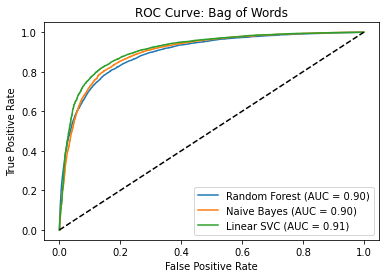

In [57]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(rf_clf, X_test_bow, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(sgdsvc_clf, X_test_bow, y_test, name='Linear SVC',ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve: Bag of Words')
plt.show()

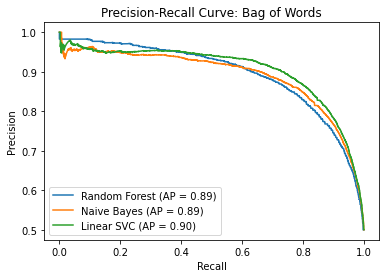

In [58]:
# plot the Precision- Recall Curve for BOW representation
fig, ax = plt.subplots()
plot_precision_recall_curve(rf_clf, X_test_bow, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_precision_recall_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes', ax=ax)
plot_precision_recall_curve(sgdsvc_clf, X_test_bow, y_test, name='Linear SVC',ax=ax)
plt.title('Precision-Recall Curve: Bag of Words')
plt.show()

There isnt a huge difference amoung the four classifiers. Linear SVC has the highest Accuracy and Area under ROC. Therefore we would pick that as the best classifer to produce confusion matrix, feature importances etc. 

In [59]:
#create a dataframe with model coefficents and feature names
df_coef_bow = pd.DataFrame({'features':  countvec.get_feature_names(),  'coef' : sgdsvc_clf.coef_.ravel()})
df_coef_bow.sort_values(by='coef', ascending=False, inplace=True)
df_coef_bow.reset_index(drop=True).round(2)

,features,coef
0,bo tak,4.02
1,tak bo,4.02
2,tak,3.73
3,not bad,1.38
4,awesom,1.36
...,...,...
995,bland,-1.42
996,wast,-1.45
997,mediocr,-1.48
998,worst,-1.57


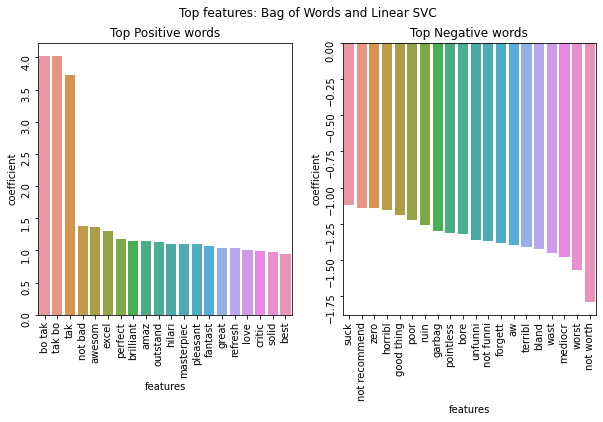

In [60]:
# top 20 positive and negative features
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef_bow.iloc[0:20, 0],y=df_coef_bow.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef_bow.iloc[-20:, 0],y=df_coef_bow.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: Bag of Words and Linear SVC')
plt.show()

*Interesting observations : Even though bigrams accounted for less than 10% of the features, 7 bigrams made it to the top 40 (17.5%). Of these 7 words 4 (not bad, not recommend, not funny, not worth) contain the word 'not'.  The bigram 'not worth' has the lowest negative coefficent while the bigram 'not bad' has the 4th highest positive coeffficent*

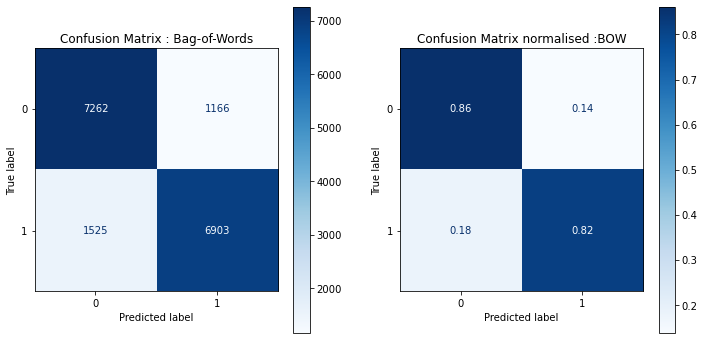

In [61]:
# Confusion Matrix, Bag of words representation
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_confusion_matrix(sgdsvc_clf, X_test_bow, y_test,cmap=plt.cm.Blues, ax=ax[0])  
ax[0].set_title('Confusion Matrix : Bag-of-Words')
plot_confusion_matrix(sgdsvc_clf, X_test_bow, y_test,cmap=plt.cm.Blues, normalize='true', ax=ax[1])  
ax[1].set_title('Confusion Matrix normalised :BOW')
plt.show()

In [62]:
# make prediction using the best classifier
y_pred_bow = sgdsvc_clf.predict(X_test_bow)
# classification report 
print(classification_report(y_test, y_pred_bow))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      8428
           1       0.86      0.82      0.84      8428

    accuracy                           0.84     16856
   macro avg       0.84      0.84      0.84     16856
weighted avg       0.84      0.84      0.84     16856



Similar accuracy on the excluded positive samples

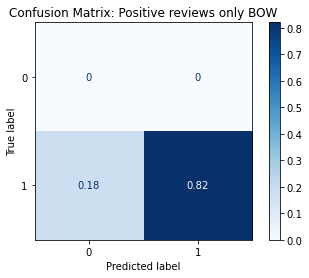

In [156]:
# Confusion matrix for the positive classes excluded in the sampling
plot_confusion_matrix(sgdsvc_clf, X_positive_bow, y_positive,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix: Positive reviews only BOW')
plt.show()

###  <font color='navy'>2. Prediction using TF-IDF sparse matrix and  multiple Classifiers</font>

In [64]:
#instantiate the Vectorizer
# Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2)) 

In [65]:
#similar to what we did before for countvec. 
bag_tfidf = Tfidf_vect.fit_transform(X_data_train) 

In [66]:
# Create X_train and X_test
X_train_tfidf= bag_tfidf.toarray() # scikit learn cant work with sparse matrices, so convert csr matrix to numpy array

# No refitting. Only transformation using the TfidfVectorizer fitted on training data.  otherwsie it would be cheating
X_test_tfidf = Tfidf_vect.transform(X_data_test).toarray()

In [67]:
# tf-idf representation of postive samples excluded
X_positive_tfidf = Tfidf_vect.transform(X_postive_data).toarray()

In [68]:
# instantiate all classifiers with default settings
clf_rf = RandomForestClassifier(random_state=SEED)
clf_nb = MultinomialNB() 
clf_sgdsvc =SGDClassifier(loss='hinge', random_state=SEED)

In [69]:
# make a list of classifiers  
classifiers = [clf_rf, clf_nb, clf_sgdsvc]

In [70]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest tf-idf', 'Naive Bayes tf-idf', 'Linear SVC tf-idf']

In [71]:
# Metrics of interest 
mean_cv_scores = []
clf_accuracy = []
clf_precision=[]
clf_recall = []
clf_f1score=[]
clf_kappa =[]

In [72]:
# for each classifier in the classifier above do the following.
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_tfidf,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    mean_cv_scores.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_tfidf, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_tfidf)
    
    # calculate and append the metrics of interest
    clf_accuracy.append(accuracy_score(y_test, y_pred)) 
    clf_precision.append(precision_score(y_test, y_pred))
    clf_recall.append(recall_score(y_test, y_pred))
    clf_f1score.append(f1_score(y_test, y_pred))
    clf_kappa.append(cohen_kappa_score(y_test, y_pred))

In [73]:
#create a summary dataframe  
df_summary = pd.DataFrame(list(zip(names, mean_cv_scores,clf_accuracy,clf_precision,clf_recall, clf_f1score,clf_kappa)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [74]:
df_summary.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest tf-idf,0.830,0.831,0.841,0.815,0.828,0.661
1,Naive Bayes tf-idf,0.828,0.829,0.844,0.808,0.826,0.659
2,Linear SVC tf-idf,0.840,0.847,0.850,0.842,0.846,0.694


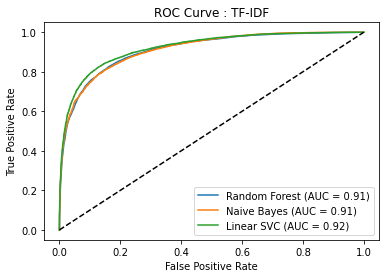

In [75]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(clf_sgdsvc, X_test_tfidf, y_test, name='Linear SVC', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve : TF-IDF')
plt.show()

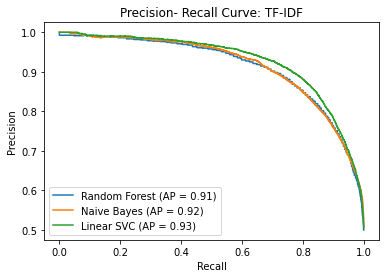

In [76]:
# plot the Precision- Recall Curve for TF-IDF representation
fig, ax = plt.subplots()
plot_precision_recall_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_precision_recall_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes', ax=ax)
plot_precision_recall_curve(clf_sgdsvc, X_test_tfidf, y_test, name='Linear SVC', ax=ax)
plt.title('Precision- Recall Curve: TF-IDF')
plt.show()

Linear SVC comes out as the best classifer based on the area under roc curve (0.92), precision-recall curve and the highest accuracy of 0.858 in both cross validation and test set. This is consistent with Literature review

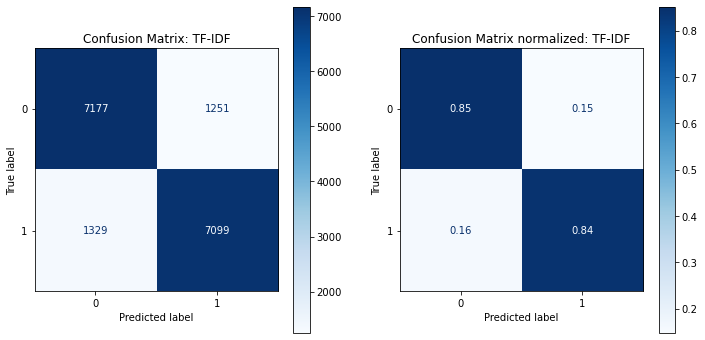

In [77]:
# plot confusion matrix side by side (for report)
# Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_confusion_matrix(clf_sgdsvc, X_test_tfidf, y_test, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix: TF-IDF')
plot_confusion_matrix(clf_sgdsvc, X_test_tfidf, y_test, cmap=plt.cm.Blues,normalize='true', ax=ax[1])  
ax[1].set_title('Confusion Matrix normalized: TF-IDF')
plt.show()

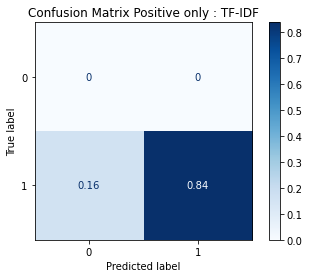

In [78]:
#plot confusion matrix normalized (Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
plot_confusion_matrix(clf_sgdsvc, X_positive_tfidf, y_positive, cmap=plt.cm.Blues,normalize='true')  
plt.title('Confusion Matrix Positive only : TF-IDF')
plt.show()

In [79]:
y_pred_tfidf = clf_sgdsvc.predict(X_test_tfidf)
# classification report 
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      8428
           1       0.85      0.84      0.85      8428

    accuracy                           0.85     16856
   macro avg       0.85      0.85      0.85     16856
weighted avg       0.85      0.85      0.85     16856



In [80]:
#create a dataframe with model coefficents and feature names
df_coef = pd.DataFrame({'features':  Tfidf_vect.get_feature_names(),  'coef' : clf_sgdsvc.coef_.ravel()})
df_coef.sort_values(by='coef', ascending=False, inplace=True)
df_coef.reset_index(drop=True).round(2)

,features,coef
0,great,3.74
1,amaz,3.73
2,enjoy,3.52
3,fun,3.51
4,awesom,3.43
...,...,...
995,wast,-3.08
996,poor,-3.23
997,terribl,-3.55
998,worst,-3.72


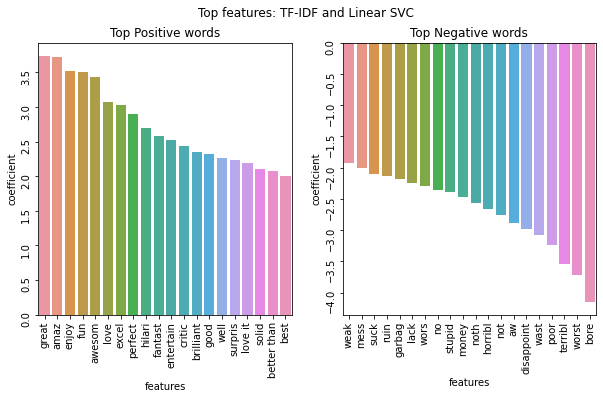

In [81]:
# top 20 postive and negative words
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef.iloc[0:20, 0],y=df_coef.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef.iloc[-20:, 0],y=df_coef.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: TF-IDF and Linear SVC ')
plt.show()

In contrast to BOW representation, only two bi-grams appear among the top 20 positive and negative words

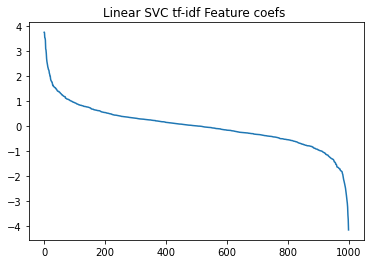

In [158]:
# SGD classifier uses L2 penatly. This shriks non-contributing coefficents towards zero (can aid in feature selection)
plt.plot(np.arange(0,1000), df_coef.coef)
plt.title('Linear SVC tf-idf Feature coefs ')
plt.show()

In [83]:
# out of the 1000 features only 177 has a coefficent >1
df_coef[abs(df_coef.coef)>1].shape[0]

177

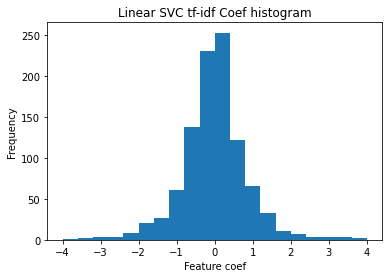

In [159]:
# features coefs historgram (same info presented differently)
plt.hist(df_coef.coef, bins=20, range=[-4,4])
plt.xlabel('Feature coef')
plt.ylabel('Frequency')
plt.title('Linear SVC tf-idf Coef histogram')
plt.show()

**Combine results of both BOW and TF-IDF representations**

In [85]:
# Combine results of BOW and TF-IDF
df_combined = pd.concat([df_summary_bow, df_summary], axis=0).reset_index(drop=True)
df_combined.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest BOW,0.821,0.817,0.821,0.812,0.816,0.635
1,Naive Bayes BOW,0.830,0.828,0.821,0.838,0.830,0.656
2,Linear SVC BOW,0.837,0.840,0.855,0.819,0.837,0.681
3,Random Forest tf-idf,0.830,0.831,0.841,0.815,0.828,0.661
4,Naive Bayes tf-idf,0.828,0.829,0.844,0.808,0.826,0.659
5,Linear SVC tf-idf,0.840,0.847,0.850,0.842,0.846,0.694


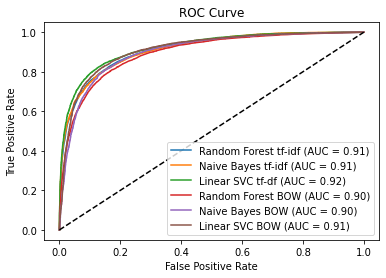

In [86]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest tf-idf', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes tf-idf', ax=ax)
plot_roc_curve(clf_sgdsvc, X_test_tfidf, y_test, name='Linear SVC tf-df', ax=ax)
plot_roc_curve(rf_clf, X_test_bow, y_test, name='Random Forest BOW', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes BOW', ax=ax)
plot_roc_curve(sgdsvc_clf, X_test_bow, y_test, name='Linear SVC BOW',ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

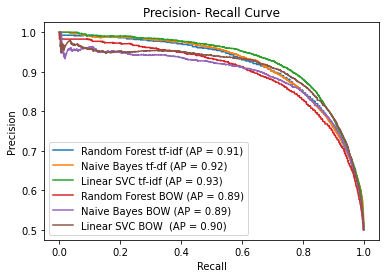

In [87]:
# plot the Precision- Recall Curve for TF-IDF representation
fig, ax = plt.subplots()
plot_precision_recall_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest tf-idf', ax=ax) #specify axis to plot all roc curves on the same axis
plot_precision_recall_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes tf-df', ax=ax)
plot_precision_recall_curve(clf_sgdsvc, X_test_tfidf, y_test, name='Linear SVC tf-idf', ax=ax)
plot_precision_recall_curve(rf_clf, X_test_bow, y_test, name='Random Forest BOW', ax=ax) #specify axis to plot all roc curves on the same axis
plot_precision_recall_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes BOW', ax=ax)
plot_precision_recall_curve(sgdsvc_clf, X_test_bow, y_test, name='Linear SVC BOW ',ax=ax)
plt.title('Precision- Recall Curve')
plt.show()

Based on ROC AUC curve, precision-recall curve and F1 score and kappa score Linear SVC with TF-IDF representation appears to be the best model. Although the difference between Linear SVC with Bag of wrods and TF IDF representation is only marginal 

##### <b> *Fine tuning the best class (hyperparameter optimization): Linear SVC - TF IDF*</b>

I will carry out a hyperparameter optimization to see if we can improve on the default model parameters 

In [88]:
# default alpha value is 0.0001
clf_sgdsvc.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [89]:
# We set random_state for reproducibility 
clf_sgd = SGDClassifier(loss ='hinge', random_state=SEED)

# Instantiate the GridSearchCV object 
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1],  # alpha is the regularization parameter (higher alpha means more regulization) default is 0.0001
             }  

gs_sgd = GridSearchCV(estimator=clf_sgd, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring = 'roc_auc',
                    return_train_score=True,
                        verbose=0)

In [90]:
# run grid search (i.e fit training data)
gs_sgd.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=1411),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='roc_auc')

In [91]:
# get the top area under ROC curve (training set)
gs_sgd.best_score_

0.9213917814721533

In [92]:
#accuracy of the optimized model 
sgd_best = gs_sgd.best_estimator_
sgd_best.score(X_test_tfidf, y_test)

0.8469387755102041

In [93]:
# find the best estimator
gs_sgd.best_estimator_.get_params() 

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [94]:
#actually the best model is still the model we got with the default setting !
gs_sgd.best_estimator_.get_params()== clf_sgdsvc.get_params()

True

In this case, hyperparameter optimisation did not result in a different model. The Linear SVC with default parameters is infact the most optimal model

### 3.2.	How much can the prediction accuracy be improved by increasing the number of features?

*The choice of 1000 features was arbitrary. In this section I will examine could we have done much better by selecting more features ? (by using the best class of model Linear SVC and tf-idf matrix)*

In [95]:
# max features to iterate over 
max_features_list = [100, 200, 500, 1000, 2000, 5000, 10000]

#lists to save the results
accuracy_fs = []

for FEATURES_MAX in max_features_list:
    #instantiate the Vectorizer
    vect_tfidf  = TfidfVectorizer(max_features=FEATURES_MAX) 
    
    #create test and training sets (X variables)
    X_train_featureselect = vect_tfidf.fit_transform(X_data_train).A # dot A is the same as toarray()
    X_test_featureselect = vect_tfidf.transform(X_data_test).A
    
    # instantiate the Linear SVC classifier 
    sgd_svc = SGDClassifier(loss='hinge', random_state=SEED)
    
    # train the model 
    sgd_svc.fit(X_train_featureselect, y_train)
    
    # make prediction
    y_pred_fs = sgd_svc.predict(X_test_featureselect)
    
    #append accuracy to the list 
    accuracy_fs.append(accuracy_score(y_test, y_pred_fs))

In [96]:
#create a summary dataframe  
df_numfeatures = pd.DataFrame(list(zip(max_features_list, accuracy_fs)),
                          columns=['No of features','Accuracy']
                         )
df_numfeatures.round(3)

,No of features,Accuracy
0,100,0.726
1,200,0.781
2,500,0.831
3,1000,0.845
4,2000,0.853
5,5000,0.860
6,10000,0.860


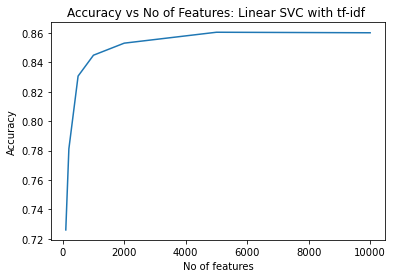

In [97]:
# plot no of featres vs accuracy 
fig , ax = plt.subplots()
ax.plot(df_numfeatures['No of features'], df_numfeatures['Accuracy'])
ax.set_title('Accuracy vs No of Features: Linear SVC with tf-idf ')
ax.set_ylabel('Accuracy')
ax.set_xlabel('No of features')
plt.show()

It looks like we could have done a little better by choosing more features. The difference in accuracy between 1000 features and 5000 features is  1.6%. However beyond 5000 features adding more features makes no difference to accuracy of the model.

### 4.Is it possible to build a model with high accuracy and less features using feature selection?

Having many features is computationally expensive and complex. In this section, I will use feature selection to demonstrate a reasonably good model can be built with only a few hundred features.

In [98]:
#create a dataframe with model coefficents of the model with 10K features
df_coef_10k= pd.DataFrame({'features':  vect_tfidf.get_feature_names(),  'coef' : sgd_svc.coef_.ravel()})
df_coef_10k.sort_values(by='coef', ascending=False, inplace=True)
df_coef_10k.reset_index(drop=True).round(2)

,features,coef
0,great,4.33
1,love,4.16
2,enjoy,3.86
3,amaz,3.66
4,fun,3.58
...,...,...
9995,not,-3.15
9996,terribl,-3.58
9997,wast,-3.68
9998,bore,-4.08


In [99]:
# from this model extract all features with coef> 1
df2 = df_coef_10k[abs(df_coef_10k.coef)>1]
my_vocabulary = list(df2.features)
len(my_vocabulary)

215

In [100]:
#instantiate the Vectorizer with the features with higher coefs only
Tfidf_vect_short  = TfidfVectorizer(vocabulary=my_vocabulary) 

# create training and test X variables
X_train_short = Tfidf_vect_short.fit_transform(X_data_train).A
X_test_short = Tfidf_vect_short.transform(X_data_test).A

In [101]:
# instantiate the classifer and train 
sgd_short = SGDClassifier(loss='hinge', random_state=SEED)
sgd_short.fit(X_train_short, y_train)
sgd_short.score(X_test_short, y_test)

0.834420977693403

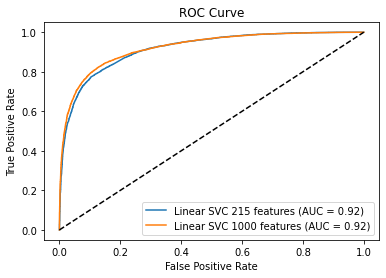

In [102]:
# plot roc curve 
fig, ax = plt.subplots()
plot_roc_curve(sgd_short, X_test_short, y_test, name='Linear SVC 215 features', ax=ax)
plot_roc_curve(clf_sgdsvc, X_test_tfidf, y_test, name='Linear SVC 1000 features', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

With only 215 of the original features the new model achieves an accuracy of 83.4% on the test set (vs 84.7% for the model with 1000 features). For comparison, simply limiting the features to 200 would have resulted in an accuracy of 78.1% (see previoous section)

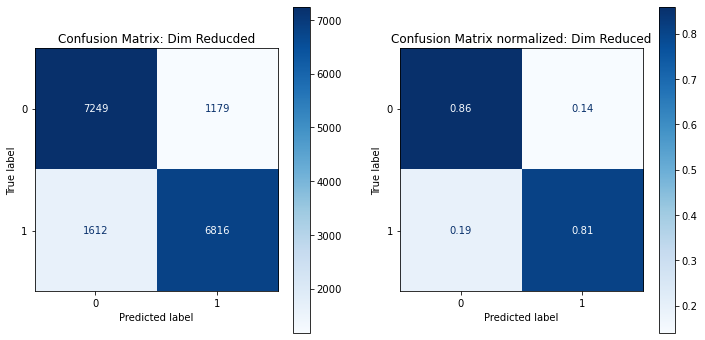

In [103]:
# plot confusion matrix side by side 
# Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_confusion_matrix(sgd_short, X_test_short, y_test, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix: Dim Reducded')
plot_confusion_matrix(sgd_short, X_test_short, y_test, cmap=plt.cm.Blues,normalize='true', ax=ax[1])  
ax[1].set_title('Confusion Matrix normalized: Dim Reduced')
plt.show()

### 5.Building a Voting Classifier

Because we have a few classifiers that are all reasonably good and performed equally well, I will build a voting classiifer and examine if a collective approach can improve the prediction accuracy.

In [104]:
classfier_list =[ ('Linear SVM', clf_sgdsvc),('Random Forest', clf_rf), ('Naive Bayes', clf_nb)]
# instantiate voting classifier VC
voting_clf = VotingClassifier(estimators = classfier_list, voting ='hard')
# Hard votig =>  Majority voting

In [105]:
#fit vc to the training set and predict test labels
voting_clf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('Linear SVM', SGDClassifier(random_state=1411)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=1411)),
                             ('Naive Bayes', MultinomialNB())])

In [106]:
#accuracy score of voting classifer
voting_clf.score(X_test_tfidf, y_test)

0.8448623635500712

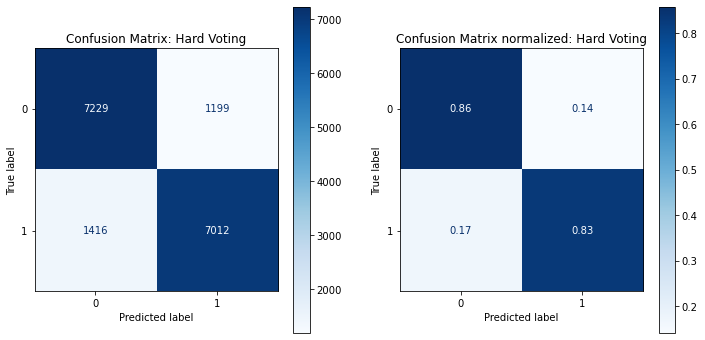

In [107]:
# plot confusion matrix side by side 
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test, cmap=plt.cm.Blues,ax=ax[0])
ax[0].set_title('Confusion Matrix: Hard Voting')
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test, cmap=plt.cm.Blues,normalize='true', ax=ax[1])  
ax[1].set_title('Confusion Matrix normalized: Hard Voting')
plt.show()

Slightly better at correctly predicting true negatives (7229 vs 7177) but slightly worse at classifying true positives (7012 vs 7099 previously). Overall a slghtly worse accuracy (0.844 vs 0.8469). Therefore the collective prediction approach did not lead to an increase in accuracy

### Comparing ML methods to popular lexicon-based classifers 

In this section, I will examine how two popular lexicon-based classifers would have performed in classifying Rotten Tomato movie reviews

In [109]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

[VADER](https://pypi.org/project/vaderSentiment/) (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  Some  of the preprocessing steps involved in training machine learning models are case normalization and the removal of punctuation, special characters, emojis. Interestingly VADER takes all of this into account for sentiment scoring. 

Lets consider the following 5 examples:
* This movie is good
* This movie is good !!!
* This movie is GOOD 
* This movie is good :) 
* This movie is good? <br>

Pre-processing steps involved in training ML models would have transformed all 5 reviews to the exact same base form. But VADER scores all 5 differently. In the second and third reviews, the use of exclamation marks and capitalization  lead to a higher sentiment score. In the fourth, use of smiley face significatly increases the probablity of the review being positive. In the final example, the use of question mark reduces the positive sentiment expressed. These qualities have made particularly useful in extracting sentiment expressed in social media, reviews etc

In [110]:
analyser = SentimentIntensityAnalyzer()
analyser.polarity_scores('This movie is good')

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [111]:
analyser.polarity_scores('This movie is good!!!')
# see both pos and compound scores have increased

{'neg': 0.0, 'neu': 0.443, 'pos': 0.557, 'compound': 0.5826}

In [112]:
analyser.polarity_scores('This movie is GOOD')

{'neg': 0.0, 'neu': 0.452, 'pos': 0.548, 'compound': 0.5622}

In [113]:
analyser.polarity_scores('This movie is good :)')

{'neg': 0.0, 'neu': 0.337, 'pos': 0.663, 'compound': 0.7096}

In [114]:
analyser.polarity_scores('This movie is good ?')

{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}

[TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) is another popular library that offers senitment analysis capabilties. Textblob sentiment returns two attributes: polarity and subjectivity. Polarity is a float ranges between -1 and +1, with +1 being most positive. Subjectivity is a float in the range the range 0 and 1 with 0.0 is being most objective and 1.0 being very subjective

Similar to VADDER, Textblob also takes into account punctuation (eg. exclamation mark). However it is not as good when it comes to handling emojis,emoticons, capitalization and special characters. 

In [115]:
TextBlob('This movie is good').sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [116]:
TextBlob('This movie is good !!!').sentiment

Sentiment(polarity=1.0, subjectivity=0.6000000000000001)

In [117]:
TextBlob('This movie is GOOD').sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [118]:
TextBlob('This movie is good :)').sentiment

Sentiment(polarity=0.6, subjectivity=0.8)

In [119]:
TextBlob('This movie is good ?').sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [120]:
# use the indexes of test dataset on original dataframe to get uncleaned version of reviews
rt_reviews.iloc[X_data_test.index].head()

,review,StarRating,sentiment,review_clean,review_stemmed
119707,Of course there were a couple Corky parts to t...,STAR_4,1,of course there were a couple corky parts to t...,of cours there were a coupl corki part to the ...
105253,This is shit with a touch of diarrhea and pee ...,STAR_0_5,0,this is shit with a touch of diarrhea and pee ...,this is shit with a touch of diarrhea and pee ...
14106,Another wonderful Kendrick Brothers presentation.,STAR_5,1,another wonderful kendrick brothers presentation,anoth wonder kendrick brother present
114667,Oh dear. This is a film that should never have...,STAR_2,0,oh dear this is a film that should never have...,oh dear this is a film that should never have ...
100770,I was looking for a movie that have all the cl...,STAR_1_5,0,i was looking for a movie that have all the cl...,i was look for a movi that have all the cliche...


In [121]:
# get original (unclean) reviews
df_X_test = rt_reviews.iloc[X_data_test.index][['review', 'sentiment']]
df_X_test.head()

,review,sentiment
119707,Of course there were a couple Corky parts to t...,1
105253,This is shit with a touch of diarrhea and pee ...,0
14106,Another wonderful Kendrick Brothers presentation.,1
114667,Oh dear. This is a film that should never have...,0
100770,I was looking for a movie that have all the cl...,0


In [122]:
# add polarity and subjectivity to each review using TextBlob
df_X_test['polarity'] = df_X_test.review.apply(lambda col: TextBlob(col).sentiment.polarity)
# df_X_test['subjectivity']= df_X_test.review_stemmed.apply(lambda col: TextBlob(col).sentiment.subjectivity)

In [123]:
# add Vader sentiment to dataframe
df_X_test['v_sentiment'] = df_X_test.review.apply(lambda col: analyser.polarity_scores(col))

In [124]:
#split the sentiment into pos, neg, neutral and compound
df_X_test['compound'] = df_X_test['v_sentiment'].apply(lambda col : col['compound'])
# df_X_test['positive'] = df_X_test.sentiment.apply(lambda col : col['pos'])
# df_X_test['negative'] = df_X_test.sentiment.apply(lambda col : col['neg'])
# df_X_test['neutal'] = df_X_test.sentiment.apply(lambda col : col['neu'])

In [125]:
# add TextBlob prediction of sentiment to DataFrame
df_X_test['TextBlob'] = df_X_test['polarity'] >0
df_X_test['TextBlob'] = df_X_test['TextBlob'].astype(int) # covernt True or False to 1 and 0

In [126]:
# add VADAR prediction of sentiment to DataFrame
df_X_test['Vader'] = df_X_test['compound'] > 0
df_X_test['Vader'] = df_X_test['Vader'].astype(int)  # covernt True or False to 1 and 0

In [127]:
#Inspect the DataFrame
df_X_test.head()

,review,sentiment,polarity,v_sentiment,compound,TextBlob,Vader
119707,Of course there were a couple Corky parts to t...,1,0.650000,"{'neg': 0.117, 'neu': 0.779, 'pos': 0.104, 'co...",-0.1045,1,0
105253,This is shit with a touch of diarrhea and pee ...,0,-0.200000,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",-0.5574,0,0
14106,Another wonderful Kendrick Brothers presentation.,1,1.000000,"{'neg': 0.0, 'neu': 0.519, 'pos': 0.481, 'comp...",0.5719,1,1
114667,Oh dear. This is a film that should never have...,0,0.287500,"{'neg': 0.034, 'neu': 0.785, 'pos': 0.181, 'co...",0.9161,1,1
100770,I was looking for a movie that have all the cl...,0,-0.762939,"{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...",0.8257,0,1


In [128]:
# Accuracy of TextBlob (in test set)
(df_X_test['sentiment'] == df_X_test['TextBlob']).mean()
# calculating the mean is a short cut to summing boolean values (1s and 0s) and dividing by total

0.7323801613668723

In [129]:
# define a function to plot confusion Matrix that looks very similar to the sklearn implementation
def plot_cfMatrix(y, y_pred, title='Confusion Matrix', x_label='Predicted Label', y_label='True Label') : 
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(pd.crosstab(y, y_pred), cmap=plt.cm.Blues,annot=True, fmt='g', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

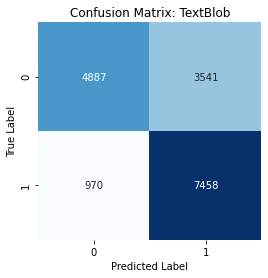

In [130]:
# Confusion Matrix :TextBlob 
plot_cfMatrix(df_X_test['sentiment'], df_X_test['TextBlob'], 'Confusion Matrix: TextBlob')

In [131]:
# Accuracy of VADAR (in test set)
(df_X_test['sentiment'] == df_X_test['Vader']).mean()

0.7348718557190318

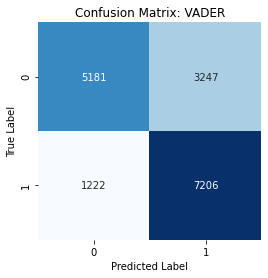

In [132]:
# Confusion Matrix: VADER
plot_cfMatrix(df_X_test['sentiment'], df_X_test['Vader'], 'Confusion Matrix: VADER')

Both TextBlob and VADER performed similarly on test set with accuracy scores of 0.732 and 0.734 but considerably worse than all 3 ML models. Further, true positive rate (sensitivity) of both TextBlob and VADER are much higher than true negative rate ( specificity) 

### *The following sections were not included in the write up*

### Appendix 1  :Can a hybrid classifier do better?

In [133]:
# add predictions of Naive Bayes and Random Forest to datafraem
df_X_test['NB Pred'] = clf_rf.predict(X_test_tfidf)
df_X_test['RF Pred'] = clf_nb.predict(X_test_tfidf)

In this section I will attempt to build a novel hybrid classifer to check if blending ML classification models with lexicon-based classification can result in better prediction accuracy.
In order to do this, I will convert Naive Bayes and Random Forest prediction probabities into a -1 to +1 score so they can be compared like-for-like with lexicon based scoring . <br> 

Then I will look at 2 hybrid prediction approaches:
* Hybrid classification = Highest score out of the 4 (ignoring sign, i.e the most confident model)
* Hybrid classification = Average score of the 4 

In [134]:
# predict probabilities of sentiment is positive using Naive Bayes and Randon Forest 
# Note the predict_proba is not defined for Linear SVC classifier
y_prob_rf = clf_rf.predict_proba(X_test_tfidf)[:,1]
y_prob_nb = clf_nb.predict_proba(X_test_tfidf)[:,1]
df_X_test['RF prob'] = y_prob_rf
df_X_test['NB prob'] = y_prob_nb

In [135]:
# transform probablity into a score betweeen -1 and 1.
df_X_test['NB score'] = df_X_test['NB prob'] * 2  # probability becomes a score between 0 and 2
df_X_test['NB score'] = df_X_test['NB score'] -1 # score is transformed between -1 and 1

df_X_test['RF score'] = df_X_test['RF prob'] * 2  # probability becomes a score between 0 and 2
df_X_test['RF score'] = df_X_test['RF score'] -1 # score is transformed between -1 and 1

In [136]:
# Review scores using all 4 methods on the same scale
df_X_test[['polarity', 'compound', 'NB score', 'RF score']]

,polarity,compound,NB score,RF score
119707,0.650000,-0.1045,0.212319,0.32
105253,-0.200000,-0.5574,0.380611,-0.02
14106,1.000000,0.5719,0.470865,0.92
114667,0.287500,0.9161,-0.397920,-0.16
100770,-0.762939,0.8257,-0.255728,-0.28
...,...,...,...,...
168372,-0.231852,-0.5574,-0.429439,-0.62
163828,0.050000,0.7589,-0.537577,0.26
93064,0.000000,-0.6476,-0.399430,-0.56
69393,-0.087500,-0.4070,-0.401049,-0.86


In [137]:
maxCol=lambda x: max(x.min(), x.max(), key=abs)

# Maximum ignoring case and average of all 4
df_X_test['Hybrid Max Score'] = df_X_test[['polarity', 'compound', 'NB score', 'RF score']].apply(maxCol,axis=1)
df_X_test['Hybrid Average Score'] = df_X_test[['polarity', 'compound', 'NB score', 'RF score']].mean(axis=1)

# Classification using Max of all 4 (most confident classifier)
df_X_test['Hybrid Max'] = df_X_test['Hybrid Max Score'] > 0
df_X_test['Hybrid Max'] = df_X_test['Hybrid Max'].astype(int)

# Classification using avg of all 4 
df_X_test['Hybrid Avg'] = df_X_test['Hybrid Average Score'] > 0
df_X_test['Hybrid Avg'] = df_X_test['Hybrid Avg'].astype(int)

In [138]:
df_X_test [['sentiment', 'polarity', 'compound', 'NB score', 'RF score','Hybrid Max Score',
            'Hybrid Average Score','Hybrid Max', 'Hybrid Avg']].head().round(2)

,sentiment,polarity,compound,NB score,RF score,Hybrid Max Score,Hybrid Average Score,Hybrid Max,Hybrid Avg
119707,1,0.65,-0.10,0.21,0.32,0.65,0.27,1,1
105253,0,-0.20,-0.56,0.38,-0.02,-0.56,-0.10,0,0
14106,1,1.00,0.57,0.47,0.92,1.00,0.74,1,1
114667,0,0.29,0.92,-0.40,-0.16,0.92,0.16,1,1
100770,0,-0.76,0.83,-0.26,-0.28,0.83,-0.12,1,0


In [139]:
#accuracy of hybrid Max classification 
(df_X_test['sentiment'] == df_X_test['Hybrid Max']).mean().round(3)

0.803

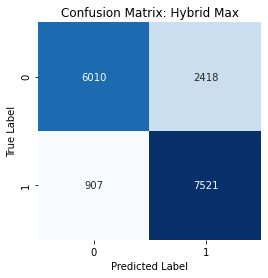

In [140]:
# Confusion Matrix: Hybrid Max
plot_cfMatrix(df_X_test['sentiment'], df_X_test['Hybrid Max'], 'Confusion Matrix: Hybrid Max')

In [141]:
#accuracy of hybrid avg classification 
(df_X_test['sentiment'] == df_X_test['Hybrid Avg']).mean().round(3)

0.82

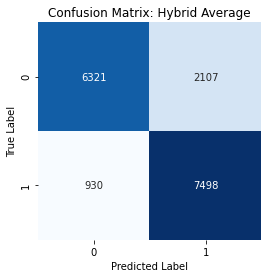

In [142]:
# Confusion Matrix: Hybrid Avg
plot_cfMatrix(df_X_test['sentiment'], df_X_test['Hybrid Avg'], 'Confusion Matrix: Hybrid Average')

Unforetuantely , the accuracy of hybrid approach is not greater than the best ML model

### Appendix  2: How the classifiers would have performed in imbalanced dataset

In this section we will look at how the classifers would have performed if we had trained it on the original imbalanced dataset

In [143]:
# Define X and target 
X_imbal = rt_reviews.review_stemmed
y_imbal = rt_reviews.sentiment.values # as numpy array

In [144]:
# 80% training 20% test, dataset split in stratifed fashion
X_imbaldata_train, X_imbaldata_test, y_train_imbal, y_test_imbal = train_test_split(X_imbal, y_imbal, test_size=0.2, stratify=y_imbal, random_state=SEED)

In [145]:
#instantiate the Vectorizer
vect_imbal  = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

In [146]:
# train and test matrices
X_train_imbal = vect_imbal.fit_transform(X_imbaldata_train).A
X_test_imbal =vect_imbal.transform(X_imbaldata_test).A 

In [147]:
# instantiate all classifiers with default settings
rf_imbal = RandomForestClassifier(random_state=SEED)
nb_imbal = MultinomialNB() 
svc_imbal =SGDClassifier(loss='hinge', random_state=SEED)

In [148]:
# make a list of classifiers  
classifiers_imbal = [rf_imbal, nb_imbal, svc_imbal]
#name of the classifiers in the same order as classifiers
names_imbal = ['Random Forest', 'Naive Bayes', 'Linear SVC']

In [149]:
# Metrics of interest 
mean_cv_scores_imbal = []
clf_accuracy_imbal = []
clf_balanced_accuracy_imbal =[]
clf_precision_imbal=[]
clf_recall_imbal = []
clf_f1score_imbal=[]
clf_kappa_imbal =[]

In [150]:
# for each classifier in the classifiers above do the following.
for clf in classifiers_imbal:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_imbal,y_train_imbal,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    mean_cv_scores_imbal.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_imbal, y_train_imbal)
    
    # predict test values
    y_pred_imbal = clf.predict(X_test_imbal)
    
    # calculate and append the metrics of interest
    clf_accuracy_imbal.append(accuracy_score(y_test_imbal, y_pred_imbal)) 
    clf_balanced_accuracy_imbal.append(balanced_accuracy_score(y_test_imbal, y_pred_imbal)) 
    clf_precision_imbal.append(precision_score(y_test_imbal, y_pred_imbal))
    clf_recall_imbal.append(recall_score(y_test_imbal, y_pred_imbal))
    clf_f1score_imbal.append(f1_score(y_test_imbal, y_pred_imbal))
    clf_kappa_imbal.append(cohen_kappa_score(y_test_imbal, y_pred_imbal))

The only difference here is the inclusion of balanced accuracy as one of the evaluation metrics

In [151]:
#create a summary dataframe  
df_imbal = pd.DataFrame(list(zip(names_imbal, mean_cv_scores_imbal,clf_accuracy_imbal,clf_balanced_accuracy_imbal,clf_precision_imbal, clf_recall_imbal,clf_f1score_imbal,clf_kappa_imbal)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )
df_imbal.round(3)

,Classifier,Avg CV Score,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.859,0.860,0.759,0.868,0.959,0.911,0.580
1,Naive Bayes,0.840,0.838,0.692,0.833,0.981,0.901,0.470
2,Linear SVC,0.869,0.865,0.767,0.872,0.962,0.915,0.596


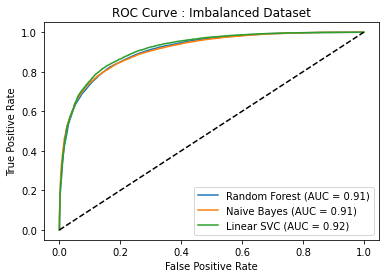

In [152]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(rf_imbal, X_test_imbal, y_test_imbal, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_imbal, X_test_imbal, y_test_imbal, name='Naive Bayes', ax=ax)
plot_roc_curve(svc_imbal, X_test_imbal, y_test_imbal, name='Linear SVC', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve : Imbalanced Dataset')
plt.show()

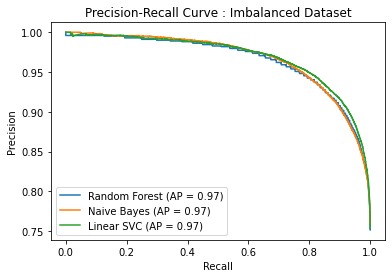

In [153]:
# plot the Precision-Recall curve
fig, ax = plt.subplots()
plot_precision_recall_curve(rf_imbal, X_test_imbal, y_test_imbal, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_precision_recall_curve(nb_imbal, X_test_imbal, y_test_imbal, name='Naive Bayes', ax=ax)
plot_precision_recall_curve(svc_imbal, X_test_imbal, y_test_imbal, name='Linear SVC', ax=ax)
plt.title('Precision-Recall Curve : Imbalanced Dataset')
plt.show()

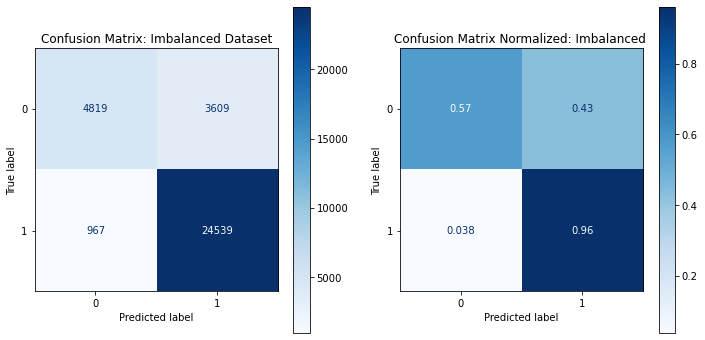

In [154]:
# plot confusion matrix side by side 
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_confusion_matrix(svc_imbal, X_test_imbal, y_test_imbal, cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix: Imbalanced Dataset')
plot_confusion_matrix(svc_imbal, X_test_imbal, y_test_imbal, cmap=plt.cm.Blues,normalize='true', ax=ax[1])  
ax[1].set_title('Confusion Matrix Normalized: Imbalanced ')
plt.show()

Extremely good at predicting the positive reviews (96%) but performs relatively poorly at correctly labelling (57%) negative reviews.
Overall accuracy is slightly better than the Linear SVC trained on the undersampled balanced dataset (86.5 vs 84.7)

### References and  Future Extensions

** Gensim is a popular open source NLP library that uses insights gained through neural network models to perform complex tasks such as building word vectors, performing topic identification and document comparison. Word vector is a multi dimensional mathematical representation of a word. This technique can used to see relationship between the words based on their proximity to each other. For example, the words king and queen relate to each other as the words man and woman (from gensim documentation)

Spacy is another python library that can transform words into vectors. 